# Make moon


As a trial to show a comparison beetween sampling/solver methods of DPMs, we decided to start by a very simple dataset - Make Moons.

## Import 

In [1]:
from typing import Tuple
import torch
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
from torch import nn
from tqdm import trange
import os
import torch
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from pytorch_fid.fid_score import calculate_frechet_distance
from diffusers import DDIMScheduler, DDPMScheduler, DPMSolverMultistepScheduler
import numpy as np
import torch
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'pytorch_fid'

## Training a diffusion denoising probabilistic models

Here we consider a forward process defined like:

$x_t = \sqrt{\alpha_t} \, x_0 + \sqrt{1 - \alpha_t} \, \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})$

To train the denoiser(neural net), we do a similar process that in the original DDPM(Denoising Diffusion Probabilistic Models) paper:

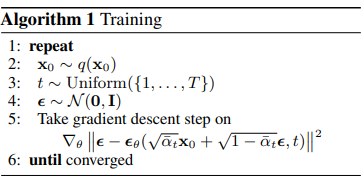


In [5]:

def linear_beta_schedule(timesteps: int, start: float = 0.0001, end: float = 0.02):
    """Creates a linear beta schedule."""
    return torch.linspace(start, end, timesteps)

# Define Forward Process
class ForwardProcess:
    def __init__(self, betas: torch.Tensor):
        self.beta = betas.to(device)
        self.alphas = 1. - betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0).to(device)  # Ensure on correct device

    def get_x_t(self, x_0: torch.Tensor, t: torch.LongTensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward diffusion process."""
        t = t.long().to(self.alpha_bar.device)  # Ensure correct dtype and device
        assert torch.all((t >= 0) & (t < len(self.alpha_bar))), f"Invalid timestep indices: {t}"
        eps_0 = torch.randn_like(x_0)
        alpha_bar = self.alpha_bar[t]
        mean = (alpha_bar ** 0.5).unsqueeze(1) * x_0
        std = ((1. - alpha_bar) ** 0.5).unsqueeze(1)
        return eps_0, mean + std * eps_0

# Define Noise Predictor Model
class NoisePredictor(nn.Module):
    def __init__(self, T: int):
        super().__init__()
        self.T = T
        self.t_encoder = nn.Linear(T, 1)  # Encode time
        self.model = nn.Sequential(
            nn.Linear(2 + 1, 50),  # Input: Noisy data x_t and t
            nn.LeakyReLU(inplace=True),
            nn.Linear(50, 50),
            nn.LeakyReLU(inplace=True),
            nn.Linear(50, 2),  # Output: Predicted noise
        )

    def forward(self, x_t, t):
        # Encode time index t
        t_embedding = self.t_encoder(
            nn.functional.one_hot(t, num_classes=self.T).float()
        )
        inp = torch.cat([x_t, t_embedding], dim=1)
        return self.model(inp)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 100 #number of steps
betas = linear_beta_schedule(T).to(device)
# import data
X, y = make_moons(n_samples=15000, noise=0.01)
X = torch.Tensor(X).to(device)
y = torch.LongTensor(y).to(device)
# Normalize data to [-1, 1]
X -= X.min(dim=0, keepdim=True)[0]
X /= X.max(dim=0, keepdim=True)[0]
X = X * 2 - 1
fp = ForwardProcess(betas=betas)
model = NoisePredictor(T=T).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-4)

# Training loop
N = X.shape[0]
for epoch in trange(15000, desc="Training"):
    t = torch.randint(low=0, high=T, size=(N,)).to(device)  # Corrected timesteps range
    eps_0, x_t = fp.get_x_t(X, t)  # Forward process
    # Predict the noise added to x_0 from x_t
    pred_eps = model(x_t, t)
    # Simplified objective without weighting with alpha terms
    loss = nn.functional.mse_loss(pred_eps, eps_0)
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/15000], Loss: {loss.item():.6f}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Training:   7%|▋         | 1109/15000 [00:01<00:22, 621.23it/s]

Epoch [1000/15000], Loss: 0.542960


Training:  14%|█▍        | 2095/15000 [00:03<00:22, 580.44it/s]

Epoch [2000/15000], Loss: 0.520659


Training:  20%|██        | 3074/15000 [00:04<00:17, 667.44it/s]

Epoch [3000/15000], Loss: 0.516599


Training:  27%|██▋       | 4091/15000 [00:06<00:16, 670.72it/s]

Epoch [4000/15000], Loss: 0.500615


Training:  34%|███▍      | 5098/15000 [00:07<00:15, 636.16it/s]

Epoch [5000/15000], Loss: 0.495352


Training:  41%|████      | 6100/15000 [00:09<00:13, 646.31it/s]

Epoch [6000/15000], Loss: 0.488938


Training:  47%|████▋     | 7068/15000 [00:11<00:13, 572.15it/s]

Epoch [7000/15000], Loss: 0.485696


Training:  54%|█████▍    | 8080/15000 [00:12<00:11, 589.30it/s]

Epoch [8000/15000], Loss: 0.476312


Training:  61%|██████    | 9077/15000 [00:14<00:09, 655.57it/s]

Epoch [9000/15000], Loss: 0.476700


Training:  67%|██████▋   | 10086/15000 [00:16<00:07, 665.93it/s]

Epoch [10000/15000], Loss: 0.477096


Training:  74%|███████▍  | 11093/15000 [00:17<00:05, 666.86it/s]

Epoch [11000/15000], Loss: 0.475158


Training:  81%|████████  | 12088/15000 [00:19<00:04, 637.06it/s]

Epoch [12000/15000], Loss: 0.473855


Training:  87%|████████▋ | 13077/15000 [00:20<00:02, 659.69it/s]

Epoch [13000/15000], Loss: 0.459215


Training:  94%|█████████▍| 14118/15000 [00:22<00:01, 638.48it/s]

Epoch [14000/15000], Loss: 0.473204


Training: 100%|██████████| 15000/15000 [00:23<00:00, 631.19it/s]

Epoch [15000/15000], Loss: 0.466398


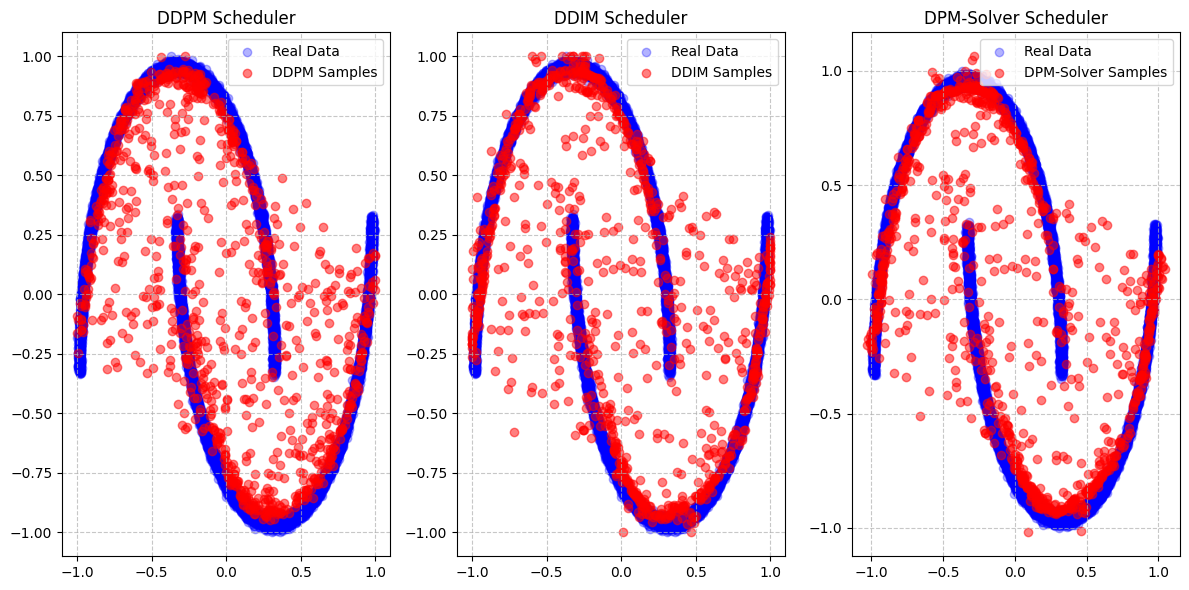

In [20]:
def sample_with_scheduler(scheduler, model, n_samples=100, nfe=5, seed=42):
    torch.manual_seed(seed)
    x = torch.randn((n_samples, 2), device=device)  # Start from random noise
    scheduler.set_timesteps(num_inference_steps=nfe, device=device)

    for t in scheduler.timesteps:
        time_tensor = torch.full((n_samples,), t, device=device)
        predicted_noise = model(x, time_tensor)
        x = scheduler.step(predicted_noise, t, x).prev_sample

    return x
def visualize_solvers(schedulers, model, n_samples=1000, seed=42):

    plt.figure(figsize=(12, 6))

    for i, (name, scheduler) in enumerate(schedulers.items(), 1):
        with torch.no_grad():
            samples = sample_with_scheduler(scheduler, model, n_samples, seed=seed)
        X_real = X.cpu().numpy()
        samples_final = samples.cpu().numpy()
        plt.subplot(1, len(schedulers), i)
        plt.scatter(X_real[:, 0], X_real[:, 1], color="blue", alpha=0.3, label="Real Data")
        plt.scatter(samples_final[:, 0], samples_final[:, 1], color="red", alpha=0.5, label=f"{name} Samples")
        plt.title(f"{name} Scheduler")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

schedulers = {
    "DDPM": DDPMScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T),
    "DDIM": DDIMScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T),
    "DPM-Solver": DPMSolverMultistepScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T, prediction_type="epsilon")
}

visualize_solvers(schedulers, model, n_samples=1000, seed=42)

Starting evaluations...
Evaluating NFE=1...
Evaluating NFE=2...
Evaluating NFE=3...
Evaluating NFE=4...
Evaluating NFE=5...
Evaluating NFE=6...
Evaluating NFE=7...
Evaluating NFE=8...
Evaluating NFE=9...
Evaluating NFE=10...


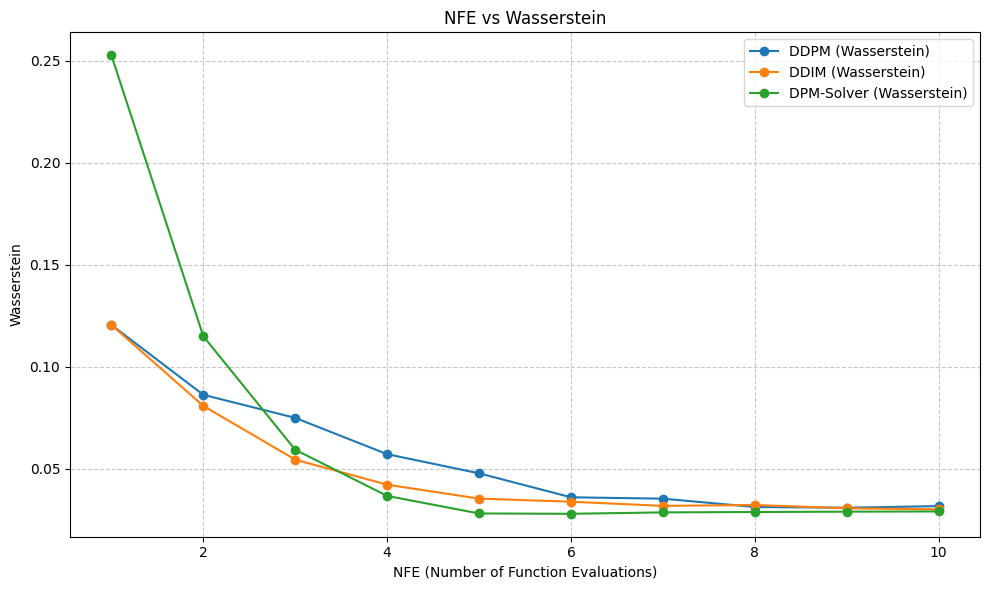

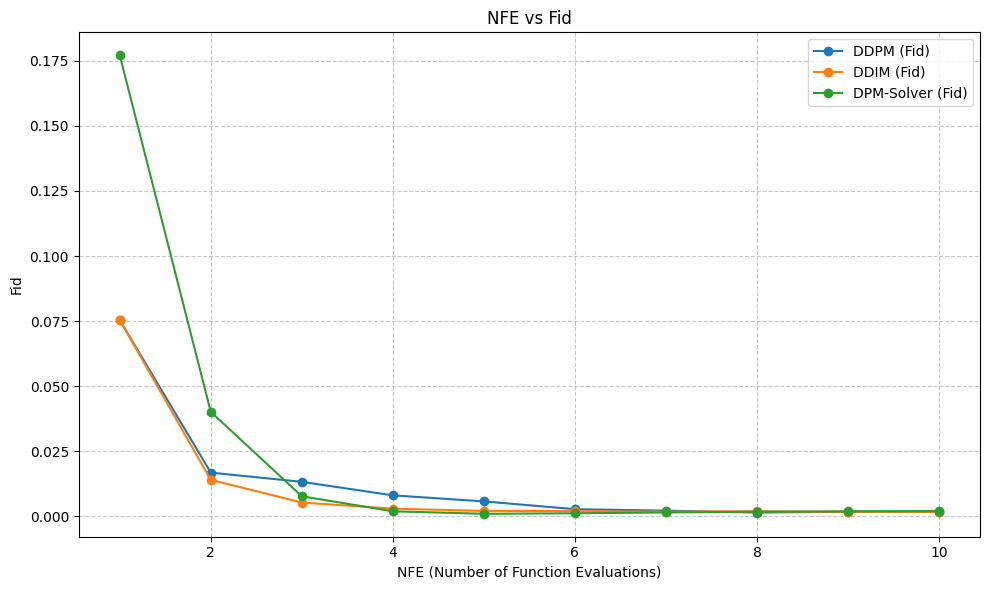

In [21]:
def evaluate_metric(scheduler, model, n_samples=1000, nfe=50, seed=42, metric="wasserstein"):
    samples = sample_with_scheduler(scheduler, model, n_samples, nfe, seed)
    real_features = X.detach().cpu().numpy() if isinstance(X, torch.Tensor) else X
    generated_features = samples.detach().cpu().numpy() if isinstance(samples, torch.Tensor) else np.asarray(samples)

    if metric == "wasserstein":
        return np.mean([
            wasserstein_distance(real_features[:, dim], generated_features[:, dim])
            for dim in range(real_features.shape[1])
        ])
    elif metric == "fid":
        mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
        mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)
        return calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    else:
        raise ValueError("Unsupported metric. Use 'wasserstein' or 'fid'.")

# Simplified scheduler evaluation
def evaluate_schedulers(schedulers, model, nfe_values, metrics=("wasserstein", "fid"), n_samples=1000, seed=42):
    results = {metric: {name: [] for name in schedulers.keys()} for metric in metrics}
    results["NFE"] = nfe_values

    for nfe in nfe_values:
        print(f"Evaluating NFE={nfe}...")
        for name, scheduler in schedulers.items():
            for metric in metrics:
                results[metric][name].append(
                    evaluate_metric(scheduler, model, n_samples, nfe, seed, metric=metric)
                )

    return results

# Plotting results
def plot_results(results, metrics=("wasserstein", "fid")):
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for name, values in results[metric].items():
            if name == "NFE":
                continue
            plt.plot(results["NFE"], values, marker="o", label=f"{name} ({metric.capitalize()})")
        plt.title(f"NFE vs {metric.capitalize()}")
        plt.xlabel("NFE (Number of Function Evaluations)")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

# Define schedulers
schedulers = {
    "DDPM": DDPMScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T),
    "DDIM": DDIMScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T),
    "DPM-Solver": DPMSolverMultistepScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T, prediction_type="epsilon")
}

# Evaluate schedulers
nfe_values = range(1, 11)  # Test NFE values from 1 to 10
metrics_to_evaluate = ("wasserstein", "fid")

print("Starting evaluations...")
evaluation_results = evaluate_schedulers(schedulers, model, nfe_values, metrics=metrics_to_evaluate)

# Plot results
plot_results(evaluation_results, metrics=metrics_to_evaluate)


## Conclusions

Since make_moons dataset seems to be a very simple dataset, we believe the comparassion beetween the three methods cannot properly be seen, once in few iterations the Wassertein and FID distances go to zero.